TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
from waveimage import calc_U

## Creation de la base d'apprentissage

In [10]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [11]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [12]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [13]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [14]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

# Construction du réseau

In [15]:
class Obj:
    pass

In [16]:
params = Obj()
params.batch_size = 100

In [17]:
batch = mnist.train.next_batch(params.batch_size)
wave_tensor = wave_tensor_data(batch[0])

Construction 
+ 5 couches convolutionnelles : 16 x 16 --> 8 x 8 ; 8 x 8 --> 4 x 4 etc
+ 1 couche FC

In [18]:
DEPTH_WAV = 3

DIM_5 = 16
WIDTH = 2

DEPTH_4 = 32
DIM_4 = DIM_5 / WIDTH # 8

DEPTH_3 = 64
DIM_3 = DIM_4 / WIDTH # 4

DEPTH_2 = 128
DIM_2 = DIM_3 / WIDTH # 2

DEPTH_1 = 256
DIM_1 = DIM_2 / WIDTH # 1

DIM_HIDDEN = 512

NB_LABEL = 10

STD = 1.

In [19]:
nb_param_54 = (DEPTH_WAV * WIDTH * WIDTH) * DEPTH_4
nb_param_43 = (DEPTH_4 * WIDTH * WIDTH) * DEPTH_3
nb_param_32 = (DEPTH_3 * WIDTH * WIDTH) * DEPTH_2
nb_param_21 = (DEPTH_2 * WIDTH * WIDTH) * DEPTH_1
nb_param_1h = (DEPTH_1 + DEPTH_WAV + 1) * DIM_HIDDEN
nb_param_hr = DIM_HIDDEN * NB_LABEL
print nb_param_54, nb_param_43, nb_param_32, nb_param_21, nb_param_1h, nb_param_hr

384 8192 32768 131072 133120 5120


In [20]:
def weight_variable(shape, stddev = 0.1, name = "dummy"):
    #initial = tf.truncated_normal(shape, stddev=0.1)
    initial = tf.random_normal(shape, stddev = stddev)
    #initial = tf.zeros(shape)
    return tf.Variable(initial, name = name)

### placeholders

In [21]:
x_5 = tf.placeholder(tf.float32, shape=[None, DIM_5, DIM_5, DEPTH_WAV])
x_4 = tf.placeholder(tf.float32, shape=[None, DIM_4, DIM_4, DEPTH_WAV])
x_3 = tf.placeholder(tf.float32, shape=[None, DIM_3, DIM_3, DEPTH_WAV])
x_2 = tf.placeholder(tf.float32, shape=[None, DIM_2, DIM_2, DEPTH_WAV])
x_1 = tf.placeholder(tf.float32, shape=[None, DIM_1, DIM_1, DEPTH_WAV])
x_0 = tf.placeholder(tf.float32, shape=[None, 1, 1, 1])
y = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)
batch_phase = tf.placeholder(tf.bool, name='bn_phase')

In [22]:
l1_loss = tf.constant(0.0)

### Layers

#### 5 --> 4

In [23]:
# Paramètres
W_conv_54 = weight_variable([WIDTH, WIDTH, DEPTH_WAV, DEPTH_4], \
                            stddev = STD / (WIDTH * WIDTH * DEPTH_WAV), \
                            name = "W_conv_54")
# Graph construction
h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_4') 
#h_pool_4 = tf.nn.max_pool(h_conv_4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_4')
#h_pool_4_bn = tf.contrib.layers.batch_norm(h_pool_4, center=True, scale=True, is_training=batch_phase, scope='h_pool_4', updates_collections=None)
z_conv_4 = tf.nn.relu(h_conv_4)

#h_conv_4 = tf.nn.conv2d(x_5, W_conv_54, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_4') 
#h_conv_4_bn = tf.contrib.layers.batch_norm(h_conv_4, center=True, scale=True, is_training=batch_phase, scope='h_conv_4', updates_collections=None)
#z_conv_4 = tf.nn.relu(h_conv_4_bn)

cat_conv_4 = tf.concat((z_conv_4, x_4), axis = 3)


#### 4 --> 3

In [24]:
# Paramètres
W_conv_43 = weight_variable([WIDTH, WIDTH, DEPTH_4 + DEPTH_WAV, DEPTH_3],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_4 + DEPTH_WAV)), \
                            name = "W_conv_43")

h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_3') 
#h_pool_3 = tf.nn.max_pool(h_conv_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_3')
#h_pool_3_bn = tf.contrib.layers.batch_norm(h_pool_3, center=True, scale=True, is_training=batch_phase, scope='h_pool_3', updates_collections=None)
z_conv_3 = tf.nn.relu(h_conv_3)

# Graph construction
#h_conv_3 = tf.nn.conv2d(cat_conv_4, W_conv_43, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_3') 
#h_conv_3_bn = tf.contrib.layers.batch_norm(h_conv_3, center=True, scale=True, is_training=batch_phase, scope='h_conv_3', updates_collections=None)
#z_conv_3 = tf.nn.relu(h_conv_3_bn)

cat_conv_3 = tf.concat((z_conv_3, x_3), axis = 3)


#### 3 --> 2

In [25]:
# Paramètres
W_conv_32 = weight_variable([WIDTH, WIDTH, DEPTH_3 + DEPTH_WAV, DEPTH_2],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_3 + DEPTH_WAV)), \
                            name = "W_conv_32")

# Graph construction
h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_2') 
#h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_2')
#h_pool_2_bn = tf.contrib.layers.batch_norm(h_pool_2, center=True, scale=True, is_training=batch_phase, scope='h_pool_2', updates_collections=None)
z_conv_2 = tf.nn.relu(h_conv_2)

#h_conv_2 = tf.nn.conv2d(cat_conv_3, W_conv_32, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_2') 
#h_conv_2_bn = tf.contrib.layers.batch_norm(h_conv_2, center=True, scale=True, is_training=batch_phase, scope='h_conv_2', updates_collections=None)
#z_conv_2 = tf.nn.relu(h_conv_2_bn)

cat_conv_2 = tf.concat((z_conv_2, x_2), axis = 3)


#### 2 --> 1

In [26]:
# Paramètres
W_conv_21 = weight_variable([WIDTH, WIDTH, DEPTH_2 + DEPTH_WAV, DEPTH_1],\
                            stddev = STD / (WIDTH * WIDTH * (DEPTH_2 + DEPTH_WAV)), \
                            name = "W_conv_21")

h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, 2, 2, 1], padding='VALID', name='h_conv_1') 
#h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='h_pool_1')
#h_pool_1_bn = tf.contrib.layers.batch_norm(h_pool_1, center=True, scale=True, is_training=batch_phase, scope='h_pool_1', updates_collections=None)
z_conv_1 = tf.nn.relu(h_conv_1)

# Graph construction
#h_conv_1 = tf.nn.conv2d(cat_conv_2, W_conv_21, strides=[1, WIDTH, WIDTH, 1], padding='VALID', name='h_conv_1') 
#h_conv_1_bn = tf.contrib.layers.batch_norm(h_conv_1, center=True, scale=True, is_training=batch_phase, scope='h_conv_1', updates_collections=None)
#z_conv_1 = tf.nn.relu(h_conv_1_bn)

cat_conv_1 = tf.concat((z_conv_1, x_1, x_0), axis = 3)
z_flat1 = tf.reshape(cat_conv_1, [-1, DEPTH_1 + DEPTH_WAV + 1])

#### hidden FC layer

In [27]:
W_hidden = weight_variable([DEPTH_1 + DEPTH_WAV + 1, DIM_HIDDEN], stddev = STD / (DEPTH_1 + DEPTH_WAV + 1), name = "W_hidden")
h_hidden = tf.matmul(z_flat1, W_hidden)
z_hidden = tf.nn.relu(h_hidden)
z_hidden_drop = tf.nn.dropout(z_hidden, keep_prob)

#### readout layer

In [28]:
W_readout = weight_variable([DIM_HIDDEN, NB_LABEL], stddev = STD / DIM_HIDDEN, name = "W_readout")
y_hat_logit = tf.matmul(z_hidden_drop, W_readout)

### Loss graph¶

In [29]:
classif_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat_logit))

l1_regularizer = tf.contrib.layers.l1_regularizer(
   scale=0.005, scope=None
)
weights = tf.trainable_variables() # all vars of your graph
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, weights)

regularized_loss = classif_loss #+ regularization_penalty # this loss needs to be min

### Train graph¶

In [30]:
train = tf.train.AdamOptimizer(1e-4).minimize(regularized_loss)

### Evaluation graph

In [31]:
correct_prediction = tf.equal(tf.argmax(y_hat_logit, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Training session

In [32]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [33]:
#file_name = "models/mnist-waveimage-CNN-backbone-512-rnd-full/mnist-waveimage-CNN-backbone-512-rnd-full"
file_name = "models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts"
saver.restore(sess,       file_name + ".ckpt")
mem    = pickle.load(open(file_name + "_mem.pkl", "rb"))

INFO:tensorflow:Restoring parameters from models/mnist-waveimage-CNN-backbone-512-rnd-parts/mnist-waveimage-CNN-backbone-512-rnd-parts.ckpt


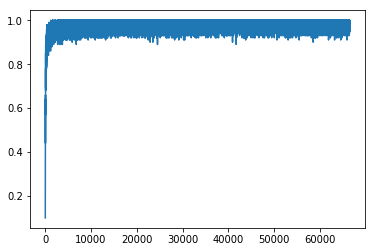

In [34]:
plt.plot(mem.classif_eval)

In [35]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [36]:
x_test, y_test = mnist.test.images, mnist.test.labels
wave_tensor = wave_tensor_data(x_test)
classif_eval = accuracy.eval(feed_dict={x_5: wave_tensor[5],\
                                        x_4: wave_tensor[4],\
                                        x_3: wave_tensor[3],\
                                        x_2: wave_tensor[2],\
                                        x_1: wave_tensor[1],\
                                        x_0: wave_tensor[0],\
                                        y: y_test,\
                                        keep_prob: 1,\
                                        batch_phase:False})
sys.stdout.write('\r classif : %.5f' \
                 % (classif_eval,))

 classif : 0.99070

## Tests single prediction

In [37]:
test_tensor = {}
test_tensor[5] = np.zeros((1, DIM_5, DIM_5, DEPTH_WAV))
test_tensor[4] = np.zeros((1, DIM_4, DIM_4, DEPTH_WAV))
test_tensor[3] = np.zeros((1, DIM_3, DIM_3, DEPTH_WAV))
test_tensor[2] = np.zeros((1, DIM_2, DIM_2, DEPTH_WAV))
test_tensor[1] = np.zeros((1, DIM_1, DIM_1, DEPTH_WAV))
test_tensor[0] = np.zeros((1, 1, 1, 1))

test = y_hat_logit.eval(feed_dict={ x_5: test_tensor[5],\
                                    x_4: test_tensor[4],\
                                    x_3: test_tensor[3],\
                                    x_2: test_tensor[2],\
                                    x_1: test_tensor[1],\
                                    x_0: test_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})

print test

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


## Baseline recognition rate

In [38]:
NB_CLASSES = 10
NB_TRIALS = 100

In [39]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [40]:
mem_classif = []
for i in range(NB_TRIALS):
    if i % 10 == 0:
        print(i)
    pi = np.ones(10) / 10
    log_score = np.zeros(10)
    mem_pi = [pi]
    x_test = mnist.test.images[i]
    y_test = mnist.test.labels[i]
    wave_tensor_test = {}
    test_size = 16 * 16
    wave_tensor_test = init_wave_tensor(test_size)
    log_score = 0
    for i_ref in range(15):
        for j_ref in range(15):
            num_test = i_ref * 16 + j_ref
            wave_tensor_tmp = wave_tensor_data_backbone(np.reshape(x_test,(1, 28 *28)), depth = -1, i_ref = i_ref, j_ref = j_ref)
            for h in range(6):
                wave_tensor_test[h][num_test] =  wave_tensor_tmp[h][0]
            
    test = y_hat_logit.eval(feed_dict={ x_5: wave_tensor_test[5],\
                                    x_4: wave_tensor_test[4],\
                                    x_3: wave_tensor_test[3],\
                                    x_2: wave_tensor_test[2],\
                                    x_1: wave_tensor_test[1],\
                                    x_0: wave_tensor_test[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})
    sum_test = np.sum(test, axis = 0)
    y_out = np.where(sum_test == max(sum_test))[0][0]
    #y_hat = np.where(y_test == max(y_test))[0][0]
    mem_classif += [y_out == y_test]


0
10
20
30
40
50
60
70
80
90


In [41]:
np.mean(mem_classif)

0.91000000000000003

9


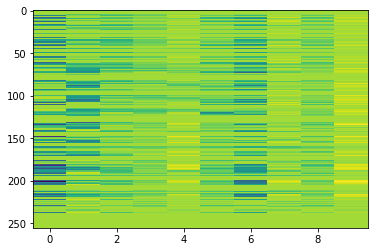

In [42]:
plt.imshow(test, aspect = 'auto')
print(y_test)

In [ ]:
np.where(np.array(mem_classif)==True,1,0).sum()/ (NB_CLASSES * NB_TRIALS / 100.0)

# Parcours predictif

In [43]:
from scipy.stats import entropy

In [44]:
mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))

In [45]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    

In [46]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [47]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [48]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [49]:
def predictive_search(sess, log_score, z_ref, actions_set, mem_h_u):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(actions_set)
    batch_predictive_tensor =  init_wave_tensor(batch_size)
    ## Parcours predictif
    dict_u = {}
    for i, u_gen in enumerate(actions_set):
        dict_u[i] = u_gen
        liste_path = calcule_asc_path(h_ref, u_gen)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            if (h_path, u_path) not in mem_h_u:
                v_predictive = argmax_generator(z_ref, h_path, u_path)
                batch_predictive_tensor[h_path][i][u_path[0]][u_path[1]][:] =  v_predictive

    log_score_path = y_hat_logit.eval(feed_dict={ x_5: batch_predictive_tensor[5],\
                                    x_4: batch_predictive_tensor[4],\
                                    x_3: batch_predictive_tensor[3],\
                                    x_2: batch_predictive_tensor[2],\
                                    x_1: batch_predictive_tensor[1],\
                                    x_0: batch_predictive_tensor[0],\
                                    keep_prob: 1,\
                                    batch_phase:False})    
    
    i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]

    pi_path = sess.run(tf.nn.softmax(log_score + log_score_path[i_max,:]))
    
    ## 3 ##
    return dict_u[i_max], pi_path[0][z_ref]
    

In [50]:
def prediction_based_policy(sess, log_score, actions_set, mem_h_u):
    
    ## 1 ##
    z_tilde = np.argmax(log_score)    
    u_tilde, _ = predictive_search(sess, log_score, z_tilde, actions_set, mem_h_u)
    
    return u_tilde

In [51]:
def saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    while (h, u_tilde) in mem_h_u:
        u_tilde = pi_predictive_sorted[z_tilde].pop()[1]
    return u_tilde
    

In [52]:
def random_policy(log_score, mem_h_u):
    h = 5
    ## 1 ##
    z_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    u_tilde = (np.random.randint(16),  np.random.randint(16))
    while (h, u_tilde) in mem_h_u:
        #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
        u_tilde = (np.random.randint(16),  np.random.randint(16))
    return u_tilde

In [53]:
def scene_exploration(sess, wave_tensor_ref, log_score, z_ref, ind_test, actions_set, mem_h_u, record, \
                      POL = 'predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert POL == 'predictive' or POL == 'saliency-based' or POL == 'random' or POL == 'full'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach
    if POL == 'saliency-based':
        pi_predictive_sorted = calc_pi_predictive_sorted(pi_predictive_eff)
    
    while END == False:
        
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'predictive':
            u_tilde = prediction_based_policy(sess, log_score, actions_set, mem_h_u)
        elif POL == 'saliency-based':
            u_tilde = saliency_based_policy(log_score, pi_predictive_sorted, mem_h_u)
        else:
            u_tilde = random_policy(log_score, mem_h_u)
        
        if AFF:
            print 'CHOIX :', u_tilde
        
        # 2. LECTURE + UPDATE
        wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_tilde)
        
        for (h_path, u_path) in reversed(liste_path):
            if (h_path, u_path) not in mem_h_u:
                wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  wave_tensor_ref[h_path][0][u_path[0]][u_path[1]][:]
                mem_h_u += [(h_path, u_path)]
                record.mem_h_u += [(h_path, u_path)]
                record.nb_coeffs += 3                
        delta_log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                            x_4: wave_tensor[4],\
                            x_3: wave_tensor[3],\
                            x_2: wave_tensor[2],\
                            x_1: wave_tensor[1],\
                            x_0: wave_tensor[0],\
                            keep_prob: 1,\
                            batch_phase:False})  
        log_score += delta_log_score
                
        pi = sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
                
        if AFF :
            print 'pi : ', pi
            print 'out :', out
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_z += [out]
                
        # 3. INHIBITION OF RETURN        
        actions_set.pop(u_tilde)
        
        record.mem_u += [u_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'z :', z_ref, ', u :',u_tilde, ' ---> ', out
              
        
        if TOUR == 16 * 16 - 1 or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return out
        else:
            TOUR += 1   

## Main

In [54]:
from record import Record, affiche_records            

In [55]:
NB_TRIALS = 1000

In [57]:
import time
dict_records = {}

for POL in ('predictive', 'saliency-based', 'random'):
    
    dict_records[POL] = {}
    
    for THRESHOLD in (1e-1, 1e-2, 1e-3, 1e-4, 1e-5):
        
        records = [] 
        cpt_TRIALS = 0
        
        tic = time.time()

        #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

        for ind_test in range(NB_TRIALS):
            if ind_test % 10 == 0:
                print(POL, THRESHOLD, ind_test)
            x_test, z_ref = mnist.test.images[ind_test], mnist.test.labels[ind_test]
            #wave_tensor = wave_tensor_data(x_test)
            wave_tensor_ref = wave_tensor_data(np.reshape(x_test,(1, 28*28)))

            # initial
            log_score = np.zeros(10)
            pi = np.ones(10) / 10
            H = entropy(pi) #np.sum(- pi * np.log(pi))

            record = Record()
            record.POL = POL
            record.THRESHOLD = THRESHOLD
            record.z_ref = z_ref
            record.mem_pi += [pi]
            record.mem_H += [H]

            # global coef --> log_score initial
            h, u = 0, (0, 0)
            mem_h_u = [(h, u)]
            wave_tensor =  init_wave_tensor(1)
            wave_tensor[0][0][0][0][0] =  wave_tensor_ref[0][0][0][0][0]
            log_score = y_hat_logit.eval(feed_dict={x_5: wave_tensor[5],\
                        x_4: wave_tensor[4],\
                        x_3: wave_tensor[3],\
                        x_2: wave_tensor[2],\
                        x_1: wave_tensor[1],\
                        x_0: wave_tensor[0],\
                        keep_prob: 1,\
                        batch_phase:False})  
            pi = sess.run(tf.nn.softmax(log_score))[0]
            H = entropy(pi) #H = sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
            z_tilde = np.argmax(pi)

            record.mem_pi += [pi]
            record.mem_H += [H]
            record.mem_z += [z_tilde]
            record.nb_coeffs += 1

            # initial actions set
            actions_set = {}
            for i in range(16):
                for j in range(16):
                    actions_set[(i, j)] = 1

            z_final = scene_exploration(sess, wave_tensor_ref, log_score, z_ref, ind_test,\
                                        actions_set, mem_h_u, record, \
                                        POL = POL, AFF = False, THRESHOLD = THRESHOLD)
            record.z_final = z_final
            record.success = z_ref == z_final

            records += [record]
                
            toc = time.time()
            print '\rPolicy : %s, threshold : %g, steps %d, classe %d, rep : %d, elapsed time : %g' \
                                % (POL, THRESHOLD, record.nb_saccades, z_ref, z_final, toc - tic)   
            cpt_TRIALS  += NB_TRIALS

        dict_records[POL][THRESHOLD] = records
        print '\n'
        print 'Nb trials :', cpt_TRIALS
        #affiche_records(records)
        print '\n'
        np.save('mnist-waveimage-CNN-backbone-records-rnd-full', dict_records)
        

('predictive', 0.1, 0)
Policy : predictive, threshold : 0.1, steps 3, classe 7, rep : 7, elapsed time : 0.196897
Policy : predictive, threshold : 0.1, steps 3, classe 2, rep : 2, elapsed time : 0.394298
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 0.465381
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 0.535736
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 0.667232
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 0.737231
Policy : predictive, threshold : 0.1, steps 3, classe 4, rep : 4, elapsed time : 0.924149
Policy : predictive, threshold : 0.1, steps 15, classe 9, rep : 9, elapsed time : 1.8601
Policy : predictive, threshold : 0.1, steps 2, classe 5, rep : 5, elapsed time : 2.01184
Policy : predictive, threshold : 0.1, steps 3, classe 9, rep : 9, elapsed time : 2.2229
('predictive', 0.1, 10)
Policy : predictive, threshold : 0.1, steps 1, classe 0, 

Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 27.8768
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 28.1204
Policy : predictive, threshold : 0.1, steps 12, classe 9, rep : 9, elapsed time : 29.4982
Policy : predictive, threshold : 0.1, steps 3, classe 3, rep : 3, elapsed time : 29.841
Policy : predictive, threshold : 0.1, steps 3, classe 1, rep : 1, elapsed time : 30.2012
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 30.4601
Policy : predictive, threshold : 0.1, steps 129, classe 1, rep : 8, elapsed time : 44.7885
Policy : predictive, threshold : 0.1, steps 8, classe 7, rep : 8, elapsed time : 45.8114
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 46.1536
Policy : predictive, threshold : 0.1, steps 2, classe 9, rep : 9, elapsed time : 46.4417
('predictive', 0.1, 100)
Policy : predictive, threshold : 0.1, steps 3, classe 6, rep : 6, elapsed time : 46

Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 127.818
Policy : predictive, threshold : 0.1, steps 2, classe 8, rep : 8, elapsed time : 128.281
Policy : predictive, threshold : 0.1, steps 6, classe 5, rep : 5, elapsed time : 129.467
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 129.743
Policy : predictive, threshold : 0.1, steps 5, classe 8, rep : 8, elapsed time : 130.764
Policy : predictive, threshold : 0.1, steps 6, classe 9, rep : 9, elapsed time : 131.963
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 132.429
Policy : predictive, threshold : 0.1, steps 2, classe 5, rep : 5, elapsed time : 132.889
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 133.158
Policy : predictive, threshold : 0.1, steps 3, classe 1, rep : 1, elapsed time : 133.82
('predictive', 0.1, 190)
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 134.0

Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 214.922
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 215.282
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 215.645
Policy : predictive, threshold : 0.1, steps 3, classe 9, rep : 9, elapsed time : 216.48
Policy : predictive, threshold : 0.1, steps 3, classe 9, rep : 9, elapsed time : 217.372
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 218.036
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 218.389
Policy : predictive, threshold : 0.1, steps 1, classe 8, rep : 8, elapsed time : 218.747
Policy : predictive, threshold : 0.1, steps 3, classe 2, rep : 2, elapsed time : 219.586
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 219.951
('predictive', 0.1, 280)
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 220.5

Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 347.896
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 348.655
Policy : predictive, threshold : 0.1, steps 7, classe 2, rep : 3, elapsed time : 350.912
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 351.67
Policy : predictive, threshold : 0.1, steps 2, classe 5, rep : 5, elapsed time : 352.41
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 352.864
Policy : predictive, threshold : 0.1, steps 4, classe 6, rep : 6, elapsed time : 354.273
Policy : predictive, threshold : 0.1, steps 2, classe 5, rep : 5, elapsed time : 355.033
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 355.799
Policy : predictive, threshold : 0.1, steps 3, classe 3, rep : 3, elapsed time : 356.838
('predictive', 0.1, 370)
Policy : predictive, threshold : 0.1, steps 3, classe 7, rep : 7, elapsed time : 357.93

Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 481.272
Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 482.146
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 483.02
Policy : predictive, threshold : 0.1, steps 3, classe 3, rep : 3, elapsed time : 484.252
Policy : predictive, threshold : 0.1, steps 4, classe 9, rep : 9, elapsed time : 485.829
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 486.346
Policy : predictive, threshold : 0.1, steps 6, classe 2, rep : 2, elapsed time : 488.67
Policy : predictive, threshold : 0.1, steps 10, classe 6, rep : 6, elapsed time : 492.388
Policy : predictive, threshold : 0.1, steps 1, classe 8, rep : 8, elapsed time : 492.926
Policy : predictive, threshold : 0.1, steps 2, classe 0, rep : 0, elapsed time : 493.891
('predictive', 0.1, 460)
Policy : predictive, threshold : 0.1, steps 25, classe 5, rep : 5, elapsed time : 503.

Policy : predictive, threshold : 0.1, steps 2, classe 5, rep : 5, elapsed time : 644.785
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 645.884
Policy : predictive, threshold : 0.1, steps 3, classe 8, rep : 8, elapsed time : 647.437
Policy : predictive, threshold : 0.1, steps 25, classe 8, rep : 8, elapsed time : 658.816
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 659.89
Policy : predictive, threshold : 0.1, steps 2, classe 0, rep : 0, elapsed time : 660.963
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 661.627
Policy : predictive, threshold : 0.1, steps 3, classe 2, rep : 2, elapsed time : 663.203
Policy : predictive, threshold : 0.1, steps 6, classe 3, rep : 3, elapsed time : 666.039
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 667.121
('predictive', 0.1, 550)
Policy : predictive, threshold : 0.1, steps 9, classe 7, rep : 7, elapsed time : 671.

Policy : predictive, threshold : 0.1, steps 5, classe 9, rep : 9, elapsed time : 942.409
Policy : predictive, threshold : 0.1, steps 2, classe 8, rep : 8, elapsed time : 943.685
Policy : predictive, threshold : 0.1, steps 1, classe 2, rep : 2, elapsed time : 944.431
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 945.724
Policy : predictive, threshold : 0.1, steps 3, classe 9, rep : 9, elapsed time : 947.475
Policy : predictive, threshold : 0.1, steps 1, classe 2, rep : 2, elapsed time : 948.268
Policy : predictive, threshold : 0.1, steps 2, classe 7, rep : 7, elapsed time : 949.528
Policy : predictive, threshold : 0.1, steps 3, classe 3, rep : 3, elapsed time : 951.265
Policy : predictive, threshold : 0.1, steps 6, classe 5, rep : 5, elapsed time : 954.5
Policy : predictive, threshold : 0.1, steps 6, classe 9, rep : 9, elapsed time : 957.871
('predictive', 0.1, 640)
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 958.63

Policy : predictive, threshold : 0.1, steps 3, classe 5, rep : 8, elapsed time : 1163.6
Policy : predictive, threshold : 0.1, steps 2, classe 0, rep : 0, elapsed time : 1165.11
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 1166.52
Policy : predictive, threshold : 0.1, steps 2, classe 0, rep : 0, elapsed time : 1168.11
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 1169.72
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 1170.6
Policy : predictive, threshold : 0.1, steps 15, classe 7, rep : 7, elapsed time : 1179.39
Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 1180.82
Policy : predictive, threshold : 0.1, steps 3, classe 2, rep : 2, elapsed time : 1182.79
Policy : predictive, threshold : 0.1, steps 3, classe 6, rep : 6, elapsed time : 1184.77
('predictive', 0.1, 730)
Policy : predictive, threshold : 0.1, steps 2, classe 7, rep : 7, elapsed time : 1186.

Policy : predictive, threshold : 0.1, steps 3, classe 7, rep : 2, elapsed time : 20152.6
Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 20154.3
Policy : predictive, threshold : 0.1, steps 2, classe 5, rep : 5, elapsed time : 20156
Policy : predictive, threshold : 0.1, steps 6, classe 9, rep : 9, elapsed time : 20160.1
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 20161.7
Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 20163.5
Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 20165.9
Policy : predictive, threshold : 0.1, steps 12, classe 6, rep : 6, elapsed time : 20175.7
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 20176.9
Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 20178.7
('predictive', 0.1, 820)
Policy : predictive, threshold : 0.1, steps 2, classe 6, rep : 6, elapsed time : 20180

Policy : predictive, threshold : 0.1, steps 2, classe 1, rep : 1, elapsed time : 20524.7
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 20526.4
Policy : predictive, threshold : 0.1, steps 3, classe 4, rep : 4, elapsed time : 20528.9
Policy : predictive, threshold : 0.1, steps 3, classe 6, rep : 6, elapsed time : 20531.5
Policy : predictive, threshold : 0.1, steps 2, classe 0, rep : 0, elapsed time : 20533.3
Policy : predictive, threshold : 0.1, steps 1, classe 2, rep : 2, elapsed time : 20534.5
Policy : predictive, threshold : 0.1, steps 4, classe 9, rep : 7, elapsed time : 20537.8
Policy : predictive, threshold : 0.1, steps 1, classe 1, rep : 1, elapsed time : 20539
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 20540.8
Policy : predictive, threshold : 0.1, steps 3, classe 7, rep : 7, elapsed time : 20543.5
('predictive', 0.1, 910)
Policy : predictive, threshold : 0.1, steps 2, classe 4, rep : 4, elapsed time : 20545.

Policy : predictive, threshold : 0.1, steps 2, classe 2, rep : 2, elapsed time : 20880.6
Policy : predictive, threshold : 0.1, steps 2, classe 3, rep : 3, elapsed time : 20882.7
Policy : predictive, threshold : 0.1, steps 9, classe 9, rep : 9, elapsed time : 20890.7
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 20891.8
Policy : predictive, threshold : 0.1, steps 2, classe 1, rep : 1, elapsed time : 20893.7
Policy : predictive, threshold : 0.1, steps 1, classe 2, rep : 2, elapsed time : 20894.9
Policy : predictive, threshold : 0.1, steps 1, classe 2, rep : 2, elapsed time : 20896
Policy : predictive, threshold : 0.1, steps 1, classe 0, rep : 0, elapsed time : 20897.2
Policy : predictive, threshold : 0.1, steps 1, classe 8, rep : 8, elapsed time : 20898.3
Policy : predictive, threshold : 0.1, steps 6, classe 9, rep : 9, elapsed time : 20903.2


Nb trials : 1000000


('predictive', 0.01, 0)
Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 

Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 7, elapsed time : 595.588
('predictive', 0.01, 80)
Policy : predictive, threshold : 0.01, steps 4, classe 7, rep : 7, elapsed time : 599.425
Policy : predictive, threshold : 0.01, steps 2, classe 6, rep : 6, elapsed time : 601.555
Policy : predictive, threshold : 0.01, steps 1, classe 2, rep : 2, elapsed time : 602.824
Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 7, elapsed time : 605.827
Policy : predictive, threshold : 0.01, steps 3, classe 8, rep : 8, elapsed time : 608.821
Policy : predictive, threshold : 0.01, steps 2, classe 4, rep : 4, elapsed time : 610.974
Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 7, elapsed time : 613.951
Policy : predictive, threshold : 0.01, steps 9, classe 3, rep : 3, elapsed time : 622.184
Policy : predictive, threshold : 0.01, steps 3, classe 6, rep : 6, elapsed time : 625.205
Policy : predictive, threshold : 0.01, steps 1, classe 1, rep : 1, elapsed 

Policy : predictive, threshold : 0.01, steps 3, classe 1, rep : 1, elapsed time : 1117.33
Policy : predictive, threshold : 0.01, steps 6, classe 4, rep : 4, elapsed time : 1123.42
('predictive', 0.01, 170)
Policy : predictive, threshold : 0.01, steps 6, classe 4, rep : 4, elapsed time : 1129.49
Policy : predictive, threshold : 0.01, steps 19, classe 7, rep : 7, elapsed time : 1147.74
Policy : predictive, threshold : 0.01, steps 16, classe 2, rep : 2, elapsed time : 1163.15
Policy : predictive, threshold : 0.01, steps 8, classe 3, rep : 3, elapsed time : 1171.14
Policy : predictive, threshold : 0.01, steps 2, classe 2, rep : 2, elapsed time : 1173.47
Policy : predictive, threshold : 0.01, steps 256, classe 7, rep : 9, elapsed time : 1419.92
Policy : predictive, threshold : 0.01, steps 3, classe 1, rep : 1, elapsed time : 1423.35
Policy : predictive, threshold : 0.01, steps 6, classe 8, rep : 8, elapsed time : 1429.7
Policy : predictive, threshold : 0.01, steps 1, classe 1, rep : 1, elap

Policy : predictive, threshold : 0.01, steps 11, classe 8, rep : 8, elapsed time : 2861.36
Policy : predictive, threshold : 0.01, steps 2, classe 2, rep : 2, elapsed time : 2864.3
Policy : predictive, threshold : 0.01, steps 4, classe 6, rep : 0, elapsed time : 2869.62
('predictive', 0.01, 260)
Policy : predictive, threshold : 0.01, steps 3, classe 8, rep : 8, elapsed time : 2873.77
Policy : predictive, threshold : 0.01, steps 9, classe 5, rep : 5, elapsed time : 2884.95
Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 7, elapsed time : 2889.1
Policy : predictive, threshold : 0.01, steps 5, classe 7, rep : 7, elapsed time : 2895.59
Policy : predictive, threshold : 0.01, steps 256, classe 9, rep : 8, elapsed time : 3203.17
Policy : predictive, threshold : 0.01, steps 2, classe 1, rep : 1, elapsed time : 3206.23
Policy : predictive, threshold : 0.01, steps 6, classe 8, rep : 8, elapsed time : 3214.24
Policy : predictive, threshold : 0.01, steps 1, classe 1, rep : 1, elapse

Policy : predictive, threshold : 0.01, steps 12, classe 0, rep : 0, elapsed time : 4458.54
Policy : predictive, threshold : 0.01, steps 9, classe 5, rep : 5, elapsed time : 4471.62
Policy : predictive, threshold : 0.01, steps 2, classe 1, rep : 1, elapsed time : 4475.02
Policy : predictive, threshold : 0.01, steps 40, classe 3, rep : 9, elapsed time : 4530.5
('predictive', 0.01, 350)
Policy : predictive, threshold : 0.01, steps 3, classe 1, rep : 1, elapsed time : 4535.29
Policy : predictive, threshold : 0.01, steps 5, classe 5, rep : 5, elapsed time : 4542.86
Policy : predictive, threshold : 0.01, steps 7, classe 5, rep : 0, elapsed time : 4553.17
Policy : predictive, threshold : 0.01, steps 3, classe 6, rep : 6, elapsed time : 4558
Policy : predictive, threshold : 0.01, steps 2, classe 1, rep : 1, elapsed time : 4561.44
Policy : predictive, threshold : 0.01, steps 5, classe 8, rep : 8, elapsed time : 4568.98
Policy : predictive, threshold : 0.01, steps 5, classe 5, rep : 5, elapsed t

Policy : predictive, threshold : 0.01, steps 13, classe 8, rep : 8, elapsed time : 5941.62
Policy : predictive, threshold : 0.01, steps 3, classe 8, rep : 8, elapsed time : 5946.94
Policy : predictive, threshold : 0.01, steps 3, classe 3, rep : 3, elapsed time : 5952.23
Policy : predictive, threshold : 0.01, steps 21, classe 7, rep : 7, elapsed time : 5984.76
Policy : predictive, threshold : 0.01, steps 6, classe 6, rep : 6, elapsed time : 5994.82
('predictive', 0.01, 440)
Policy : predictive, threshold : 0.01, steps 1, classe 0, rep : 0, elapsed time : 5997.23
Policy : predictive, threshold : 0.01, steps 2, classe 0, rep : 0, elapsed time : 6001.07
Policy : predictive, threshold : 0.01, steps 3, classe 3, rep : 3, elapsed time : 6006.4
Policy : predictive, threshold : 0.01, steps 18, classe 0, rep : 8, elapsed time : 6034.6
Policy : predictive, threshold : 0.01, steps 23, classe 2, rep : 8, elapsed time : 6070.5
Policy : predictive, threshold : 0.01, steps 5, classe 6, rep : 0, elapse

Policy : predictive, threshold : 0.01, steps 4, classe 3, rep : 3, elapsed time : 8114.76
Policy : predictive, threshold : 0.01, steps 2, classe 0, rep : 0, elapsed time : 8119.02
Policy : predictive, threshold : 0.01, steps 3, classe 3, rep : 3, elapsed time : 8125.05
Policy : predictive, threshold : 0.01, steps 3, classe 8, rep : 8, elapsed time : 8131.08
Policy : predictive, threshold : 0.01, steps 5, classe 3, rep : 3, elapsed time : 8140.45
Policy : predictive, threshold : 0.01, steps 2, classe 1, rep : 1, elapsed time : 8144.72
('predictive', 0.01, 530)
Policy : predictive, threshold : 0.01, steps 8, classe 9, rep : 9, elapsed time : 8159.31
Policy : predictive, threshold : 0.01, steps 12, classe 3, rep : 3, elapsed time : 8180.79
Policy : predictive, threshold : 0.01, steps 7, classe 4, rep : 4, elapsed time : 8193.76
Policy : predictive, threshold : 0.01, steps 3, classe 4, rep : 4, elapsed time : 8199.8
Policy : predictive, threshold : 0.01, steps 2, classe 6, rep : 6, elapsed

Policy : predictive, threshold : 0.01, steps 7, classe 2, rep : 8, elapsed time : 9934.69
Policy : predictive, threshold : 0.01, steps 6, classe 3, rep : 3, elapsed time : 9946.86
Policy : predictive, threshold : 0.01, steps 3, classe 1, rep : 1, elapsed time : 9953.43
Policy : predictive, threshold : 0.01, steps 4, classe 9, rep : 9, elapsed time : 9961.8
Policy : predictive, threshold : 0.01, steps 13, classe 7, rep : 7, elapsed time : 9987.04
Policy : predictive, threshold : 0.01, steps 5, classe 5, rep : 5, elapsed time : 9997.36
Policy : predictive, threshold : 0.01, steps 8, classe 1, rep : 8, elapsed time : 10013.2
('predictive', 0.01, 620)
Policy : predictive, threshold : 0.01, steps 2, classe 0, rep : 0, elapsed time : 10017.9
Policy : predictive, threshold : 0.01, steps 3, classe 8, rep : 8, elapsed time : 10024.4
Policy : predictive, threshold : 0.01, steps 2, classe 4, rep : 4, elapsed time : 10029
Policy : predictive, threshold : 0.01, steps 2, classe 6, rep : 6, elapsed t

Policy : predictive, threshold : 0.01, steps 14, classe 7, rep : 7, elapsed time : 12102.8
Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 7, elapsed time : 12109.9
Policy : predictive, threshold : 0.01, steps 2, classe 0, rep : 0, elapsed time : 12114.9
Policy : predictive, threshold : 0.01, steps 3, classe 7, rep : 7, elapsed time : 12122
Policy : predictive, threshold : 0.01, steps 6, classe 9, rep : 9, elapsed time : 12135.7
Policy : predictive, threshold : 0.01, steps 18, classe 4, rep : 4, elapsed time : 12173.4
Policy : predictive, threshold : 0.01, steps 3, classe 4, rep : 4, elapsed time : 12180.5
Policy : predictive, threshold : 0.01, steps 3, classe 8, rep : 8, elapsed time : 12187.6
('predictive', 0.01, 710)
Policy : predictive, threshold : 0.01, steps 3, classe 5, rep : 5, elapsed time : 12194.6
Policy : predictive, threshold : 0.01, steps 5, classe 5, rep : 5, elapsed time : 12205.8
Policy : predictive, threshold : 0.01, steps 11, classe 4, rep : 4, elapse

Policy : predictive, threshold : 0.01, steps 10, classe 5, rep : 5, elapsed time : 14607.9
Policy : predictive, threshold : 0.01, steps 2, classe 3, rep : 3, elapsed time : 14613.4
Policy : predictive, threshold : 0.01, steps 2, classe 8, rep : 8, elapsed time : 14618.9
Policy : predictive, threshold : 0.01, steps 1, classe 0, rep : 0, elapsed time : 14622.2
Policy : predictive, threshold : 0.01, steps 10, classe 3, rep : 3, elapsed time : 14645.3
Policy : predictive, threshold : 0.01, steps 2, classe 2, rep : 2, elapsed time : 14650.8
Policy : predictive, threshold : 0.01, steps 28, classe 5, rep : 8, elapsed time : 14713.8
Policy : predictive, threshold : 0.01, steps 3, classe 1, rep : 1, elapsed time : 14721.4
Policy : predictive, threshold : 0.01, steps 1, classe 2, rep : 2, elapsed time : 14724.7
('predictive', 0.01, 800)
Policy : predictive, threshold : 0.01, steps 8, classe 8, rep : 8, elapsed time : 14743.7
Policy : predictive, threshold : 0.01, steps 4, classe 3, rep : 3, elap

Policy : predictive, threshold : 0.01, steps 4, classe 7, rep : 7, elapsed time : 17226
Policy : predictive, threshold : 0.01, steps 181, classe 4, rep : 4, elapsed time : 17657.7
Policy : predictive, threshold : 0.01, steps 16, classe 9, rep : 9, elapsed time : 17697.2
Policy : predictive, threshold : 0.01, steps 26, classe 3, rep : 3, elapsed time : 17760.5
Policy : predictive, threshold : 0.01, steps 4, classe 0, rep : 0, elapsed time : 17771.2
Policy : predictive, threshold : 0.01, steps 3, classe 6, rep : 6, elapsed time : 17779.6
Policy : predictive, threshold : 0.01, steps 3, classe 6, rep : 6, elapsed time : 17787.9
Policy : predictive, threshold : 0.01, steps 3, classe 3, rep : 3, elapsed time : 17796.4
Policy : predictive, threshold : 0.01, steps 1, classe 2, rep : 2, elapsed time : 17799.9
Policy : predictive, threshold : 0.01, steps 1, classe 1, rep : 1, elapsed time : 17803.5
('predictive', 0.01, 890)
Policy : predictive, threshold : 0.01, steps 8, classe 3, rep : 3, elaps

Policy : predictive, threshold : 0.01, steps 256, classe 4, rep : 9, elapsed time : 21281.3
('predictive', 0.01, 970)
Policy : predictive, threshold : 0.01, steps 5, classe 5, rep : 5, elapsed time : 21295.6
Policy : predictive, threshold : 0.01, steps 2, classe 4, rep : 4, elapsed time : 21302.1
Policy : predictive, threshold : 0.01, steps 1, classe 0, rep : 0, elapsed time : 21306
Policy : predictive, threshold : 0.01, steps 3, classe 6, rep : 6, elapsed time : 21315.1
Policy : predictive, threshold : 0.01, steps 2, classe 2, rep : 2, elapsed time : 21321.6
Policy : predictive, threshold : 0.01, steps 3, classe 2, rep : 2, elapsed time : 21330.7
Policy : predictive, threshold : 0.01, steps 3, classe 3, rep : 3, elapsed time : 21339.9
Policy : predictive, threshold : 0.01, steps 6, classe 1, rep : 1, elapsed time : 21356.7
Policy : predictive, threshold : 0.01, steps 5, classe 5, rep : 5, elapsed time : 21371.1
Policy : predictive, threshold : 0.01, steps 3, classe 1, rep : 1, elapsed

Policy : predictive, threshold : 0.001, steps 3, classe 1, rep : 1, elapsed time : 1833.99
Policy : predictive, threshold : 0.001, steps 12, classe 9, rep : 9, elapsed time : 1867.78
Policy : predictive, threshold : 0.001, steps 18, classe 5, rep : 5, elapsed time : 1918.04
('predictive', 0.001, 60)
Policy : predictive, threshold : 0.001, steps 3, classe 7, rep : 7, elapsed time : 1927.57
Policy : predictive, threshold : 0.001, steps 9, classe 8, rep : 8, elapsed time : 1953.46
Policy : predictive, threshold : 0.001, steps 241, classe 9, rep : 9, elapsed time : 2612.55
Policy : predictive, threshold : 0.001, steps 256, classe 3, rep : 3, elapsed time : 3322.34
Policy : predictive, threshold : 0.001, steps 9, classe 7, rep : 7, elapsed time : 3348.85
Policy : predictive, threshold : 0.001, steps 9, classe 4, rep : 4, elapsed time : 3375.47
Policy : predictive, threshold : 0.001, steps 7, classe 6, rep : 6, elapsed time : 3396.47
Policy : predictive, threshold : 0.001, steps 3, classe 4,

Policy : predictive, threshold : 0.001, steps 3, classe 1, rep : 1, elapsed time : 7301.58
Policy : predictive, threshold : 0.001, steps 4, classe 8, rep : 8, elapsed time : 7315.07
Policy : predictive, threshold : 0.001, steps 2, classe 2, rep : 2, elapsed time : 7322.48
Policy : predictive, threshold : 0.001, steps 2, classe 0, rep : 0, elapsed time : 7329.98
Policy : predictive, threshold : 0.001, steps 15, classe 2, rep : 2, elapsed time : 7376.32
('predictive', 0.001, 150)
Policy : predictive, threshold : 0.001, steps 6, classe 9, rep : 9, elapsed time : 7395.77
Policy : predictive, threshold : 0.001, steps 39, classe 9, rep : 8, elapsed time : 7514.23
Policy : predictive, threshold : 0.001, steps 8, classe 5, rep : 5, elapsed time : 7539.8
Policy : predictive, threshold : 0.001, steps 5, classe 5, rep : 5, elapsed time : 7556.33
Policy : predictive, threshold : 0.001, steps 2, classe 1, rep : 1, elapsed time : 7563.85
Policy : predictive, threshold : 0.001, steps 4, classe 5, rep

KeyboardInterrupt: 

In [ ]:
sum = 0
for i in range(len(records)):
    print(records[i].mem_H)
print sum * 1. / len(records)